# A Parts of Speech Tagger with LSTM

Now that we know how to use a dataloader, define flax modules and set up training pipelines, let's look at an actual example which will combine all of these and also take a peek at the LSTM class in flax.

For this task, we're going to use the `batterydata/pos_tagging` dataset from Huggingface Datasets. 

## Loading the dataset

This particular dataset comes with train and test splits and no validation splits. Ideally, we should have all the three splits in a model training pipeline. So one solution here is to break the train split and create train and validation splits from it.

In [1]:
from datasets import load_dataset

main_dataset = load_dataset("batterydata/pos_tagging")
train_split = main_dataset["train"]
test_split = main_dataset["test"]

In [2]:
def make_train_validation_splits(dataset_split,
                                 validation_size = 0.2,
                                 seed: int = 42):
    # make a copy of the data
    dataset_split = dataset_split.shuffle(seed=seed)
    # using the train test split method to create validation set
    dataset_split = dataset_split.train_test_split(test_size=validation_size,
                                                   shuffle=True,
                                                   seed=seed)
    return dataset_split["train"], dataset_split["test"]


train_split, validation_split = make_train_validation_splits(train_split)

## Preprocessing

So we're going to take a very pre-Transformer era approach to preprocessing the dataset here. That means no byte pair tokenisation, no attention masks. We simple tokenise the words, use them as features. Which, also, practically leads us to the following steps:

1. Tokenise
2. Create a vocabulary
3. Create a word to integer mapping (a dictionary will do)
4. Create a label to integer mapping (pos tags are labels)
5. Add out of vocabulary (OOV) and padding tokens


One caveat here is that we have to use the main train split (without creating the validation split). But you probably have noticed by now that I've left a `main_dataset` variable up there. We're going to use that one.

In [3]:
# a dict containing word -> idx mapping
# pad token is 1 by default
def map_word_to_idx(dataset_split, pad_token_idx = 1):
    unique_words = set()
    word_to_idx = dict()

    # add an out of vocab token
    oov_token = "<OOV>"
    # pad token
    pad_token = "<PAD>"

    word_to_idx[oov_token] = 0
    word_to_idx[pad_token] = pad_token_idx

    # find the unique words
    for data in dataset_split:
        words = data["words"]
        for w in words:
            unique_words.add(w)

    # add index to them
    for idx, uw in enumerate(list(unique_words)):
        word_to_idx[uw] = idx + 2  # since oov is at 0 and pad at pad_token_idx

    return word_to_idx

word_to_idx = map_word_to_idx(main_dataset["train"])

In [4]:
# pos tag -> idx mapping
def map_label_to_idx(dataset, pad_token_idx = 1):
    unique_labels = set()
    label_to_idx = dict()

    # add an out of vocab token
    oov_token = "<OOV>"
    # pad token
    pad_token = "<PAD>"

    label_to_idx[oov_token] = 0
    label_to_idx[pad_token] = pad_token_idx

    # find the unique labels
    for data in dataset:
        labels = data["labels"]
        for l in labels:
            unique_labels.add(l)

    # index
    for idx, label in enumerate(list(unique_labels)):
        label_to_idx[label] = idx + 2

    return label_to_idx

label_to_idx = map_label_to_idx(main_dataset["train"])

Perfect! Now we have everything we need to create a Dataset class and Dataloaders.

## Dataset and Dataloaders

In [5]:
import numpy as np
from torch.utils.data import Dataset



class TagDataset(Dataset):
    def __init__(self, dataset_split,
                 pad_token_idx,
                 max_seq_len,
                 word_to_idx,
                 label_to_idx) -> None:
        self.dataset = dataset_split
        self.pad_token_idx = pad_token_idx
        self.max_seq_len = max_seq_len
        self.word_to_idx = word_to_idx
        self.label_to_idx = label_to_idx

    def __len__(self) -> int:
        return len(self.dataset)

    # use word_to_idx and label_to_idx to convert
    # the string sequences to int sequences
    def __encode(self, data_instance: dict) -> tuple:
        words = data_instance["words"]
        labels = data_instance["labels"]

        # convert to int sequences
        words = [self.word_to_idx.get(w, 0) for w in words]
        labels = [self.label_to_idx.get(l) for l in labels]

        return words, labels

    def __getitem__(self, index: int) -> tuple[np.ndarray, np.ndarray]:
        data = self.dataset[index]
        words, labels = self.__encode(data)

        # padding
        words_padded = np.ones((self.max_seq_len,), dtype=np.int32) * self.pad_token_idx
        words_padded[:len(words)] = words

        labels_padded = np.ones((self.max_seq_len,), dtype=np.int32) * self.pad_token_idx
        labels_padded[:len(labels)] = labels

        # return padded words and labels
        return words_padded, labels_padded

Now we need to decide on the maximum sequence length. From some searching on the dataset, I found 300 to be a good value. You can also choose something around 280. 

In [6]:
max_seq_len = 300

train_set = TagDataset(train_split, 1, max_seq_len, word_to_idx, label_to_idx)
validation_set = TagDataset(validation_split, 1, max_seq_len, word_to_idx, label_to_idx)
test_set = TagDataset(test_split, 1, max_seq_len, word_to_idx, label_to_idx)

In [7]:
# dataloaders
import torch
import jax_dataloader as jdl

torch.manual_seed(2023)

BATCH_SIZE = 128

train_loader = jdl.DataLoader(train_set, "pytorch", batch_size=BATCH_SIZE, shuffle=True)
val_loader = jdl.DataLoader(validation_set, "pytorch", batch_size=BATCH_SIZE, shuffle=False)
test_loader = jdl.DataLoader(test_set, "pytorch", batch_size=BATCH_SIZE, shuffle=False)

## Model Definition

Time to define the model. 

In [8]:
import flax.linen as nn
from jax import random
import jax.numpy as jnp

"""
class LSTMTagger

vocab_size: int, size of the vocabulary
embedding_dimensions: int, size of the embedding dimensions
lstm_hidden_dims: int, size of the lstm hidden dimensions
n_labels: int, number of labels in the dataset (the padded size, e.g. if padding length is 100, then n_labels = 100)
training: bool, whether the model is in training mode or not
"""


class LSTMTagger(nn.Module):
    vocab_size: int
    embedding_dimensions: int
    lstm_hidden_dims: int
    n_labels: int
    lstm_seed: int
    dropout_rate: float

    def setup(self) -> None:
        # embedding layer
        self.embedding = nn.Embed(
            num_embeddings=self.vocab_size,
            features=self.embedding_dimensions,
            name="embedding")

        # lstm layer
        self.lstm = nn.OptimizedLSTMCell(features=self.lstm_hidden_dims, name="lstm")

        # dropout layer
        self.dropout = nn.Dropout(self.dropout_rate, deterministic=True)

        # dense layer
        self.dense = nn.Dense(features=self.n_labels, name="dense")

    # lstm in flax: https://flax.readthedocs.io/en/latest/api_reference/flax.linen/_autosummary/flax.linen.LSTMCell.html
    def __call__(self, words: jnp.ndarray) -> jnp.ndarray:
        x = self.embedding(words)

        carry = self.lstm.initialize_carry(random.key(self.lstm_seed), x.shape)
        carry, x = self.lstm(carry=carry, inputs=x)
        x = self.dropout(x)

        x = self.dense(x)
        x = nn.leaky_relu(x)

        return x

Let's look at the model definition a bit. We have an embedding layer to create embedding vectors, followed by an LSTM which models the text sequences, a dropout layer and finally, a dense layer to map the lstm output to labels. 

One important thing to check here is how lstm works in flax. There are multiple implementations of a LSTMCell in flax. The one used here is a more optimised version. You can read more in the docs about it's implementation. In the forward pass of the model, you've to carry the initialize the carry or the state of the lstm for each batch or call and like any flax module, it requires a PRNG key. In other frameworks (e.g. Pytorch) you don't have to explcitly set the carry. 

Another is the dropout layer in flax. It requires its own PRNG, which you have to supply during the model init. Let's see how it's done. 

In [9]:
# init the model
SEED = 2023

master_key = random.key(seed=SEED)
master_key, model_init_key = random.split(master_key)
master_key, dropout_key = random.split(master_key)
model_rngs = {"params": model_init_key, "dropout": dropout_key}

In [10]:
model_config = {
        "vocab_size": len(word_to_idx),
        "embedding_dimensions": 300,
        "lstm_hidden_dims": 300,
        "n_labels": len(label_to_idx),
        "lstm_seed": 2024,
        "dropout_rate": 0.2,
}

model = LSTMTagger(**model_config)
init_params = model.init(model_rngs, np.arange(max_seq_len))

In [11]:
# a sample forward pass
logits = model.apply(init_params, jnp.arange(300), rngs={"dropout": dropout_key})
print(logits.shape)

(300, 50)


### Training functions

In [12]:
import optax
from jax import vmap, jit

# using cross entropy
@jit
def calculate_loss(params, words, labels):
    logits = model.apply(params, words, rngs={"dropout": dropout_key})
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels)
    return loss.mean(axis=-1)


@jit
def batched_loss(params, words_batched, labels_batched):
    batch_loss = vmap(calculate_loss, in_axes=(None, 0, 0))(params, words_batched, labels_batched)
    return batch_loss.mean(axis=-1)


In [13]:
from tqdm.auto import trange, tqdm
from flax.training import train_state
from functools import partial
from jax import value_and_grad

optimiser = optax.adam(learning_rate=0.001)
init_state = train_state.TrainState.create(
    apply_fn=model.apply, # the forward function
    params=init_params,
    tx=optimiser
)
criterion = value_and_grad(batched_loss)

In [14]:
@partial(jit, static_argnums=0)
def train_step(criterion, state, words_batched, labels_batched):
    loss_value, grads = criterion(state.params, words_batched, labels_batched)
    updated_state = state.apply_gradients(grads=grads)
    return loss_value, updated_state


@partial(jit, static_argnums=0)
def validation_step(criterion, state, words_batched, labels_batched):
    loss_value, _ = criterion(state.params, words_batched, labels_batched)
    return loss_value

In [15]:
def train_model(state, train_loader, epochs=5, log_every_n_step=100):
    step_counter = 0
    train_losses = list()
    mean_validation_losses = list()
    train_acc = list()
    val_acc = list()
    test_acc = list()

    for _ in trange(epochs):
        for batch in train_loader:
            loss, state = train_step(criterion, state, *batch)
            step_counter += 1

            if step_counter % log_every_n_step == 0:
                # log train loss
                train_losses.append(loss)
                # run validation
                vlosses = list()
                for vbatch in val_loader:
                    val_loss = validation_step(criterion, state, *vbatch)
                    vlosses.append(val_loss)

                vlosses = jnp.array(vlosses)
                mean_validation_losses.append(vlosses.mean(axis=-1))

                print(
                    f"Step [{step_counter + 1}] ---- Loss/Train :: {loss} ---- Loss/Val :: {vlosses.mean(axis=-1)}")



    return state, train_losses, mean_validation_losses

### Training

In [16]:
state, train_loss, val_loss = train_model(init_state, train_loader)

  0%|          | 0/5 [00:00<?, ?it/s]

Step [101] ---- Loss/Train :: 0.22377890348434448 ---- Loss/Val :: 0.2136165350675583
Step [201] ---- Loss/Train :: 0.07820736616849899 ---- Loss/Val :: 0.07860536873340607
Step [301] ---- Loss/Train :: 0.03355073183774948 ---- Loss/Val :: 0.040820877999067307
Step [401] ---- Loss/Train :: 0.02048599347472191 ---- Loss/Val :: 0.03189530968666077


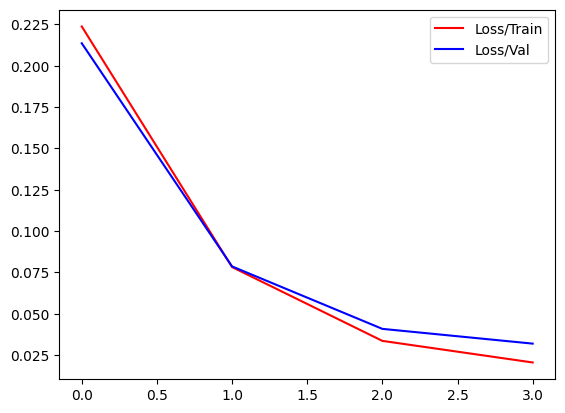

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(np.arange(len(train_loss)), train_loss, c="r", label="Loss/Train")
plt.plot(np.arange(len(val_loss)), val_loss, c="b", label="Loss/Val")
plt.legend()

## Evaluation

We're going to measure the accuracy of the models. However, the outputs are padded, so we have to ignore the padded indexes, regardless of the predictions. 

In [18]:
def categorical_accuracy(preds, actual, pad_idx=1):
    non_padding_indices = jnp.nonzero((actual != pad_idx))

    matches = jnp.equal(preds[non_padding_indices], actual[non_padding_indices])
    acc = jnp.sum(matches) / actual[non_padding_indices].shape[0]

    return acc

In [19]:
import jax.nn as jnn

@jit
def infer(params, words, labels):
    logits = model.apply(params, words, rngs={"dropout": dropout_key})
    proba = jnn.log_softmax(logits, axis=-1)
    preds = jnp.argmax(proba, axis=-1)

    return preds

@jit
def batch_infer(params, words, labels):
    preds = vmap(infer, in_axes=(None, 0, 0))(params, words, labels)
    return preds

In [20]:
def evaluate(params, test_loader):
    acc_per_batch = list()
    for batch in tqdm(test_loader):
        words, labels = batch
        preds = batch_infer(params, words, labels)

        acc = categorical_accuracy(preds, labels)
        acc_per_batch.append(acc)

    mean_acc = jnp.mean(jnp.array(acc_per_batch), axis=-1)

    return mean_acc

In [21]:
acc = evaluate(state.params, test_loader)
print(f"Accuracy on the test loader: {acc}")

  0%|          | 0/12 [00:00<?, ?it/s]

Accuracy on the test loader: 0.891249418258667
